# sklearn-LDA

代码示例：https://mp.weixin.qq.com/s/hMcJtB3Lss1NBalXRTGZlQ （玉树芝兰） <br>
可视化：https://blog.csdn.net/qq_39496504/article/details/107125284  <br>
sklearn lda参数解读:https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
<br>中文版参数解读：https://blog.csdn.net/TiffanyRabbit/article/details/76445909
<br>LDA原理-视频版：https://www.bilibili.com/video/BV1t54y127U8
<br>LDA原理-文字版：https://www.jianshu.com/p/5c510694c07e
<br>score的计算方法：https://github.com/scikit-learn/scikit-learn/blob/844b4be24d20fc42cc13b957374c718956a0db39/sklearn/decomposition/_lda.py#L729
<br>主题困惑度1：https://blog.csdn.net/weixin_43343486/article/details/109255165
<br>主题困惑度2：https://blog.csdn.net/weixin_39676021/article/details/112187210

## 1.预处理

In [46]:
import os
import pandas as pd
import re
import jieba
import jieba.posseg as psg

In [47]:
data = pd.read_csv("微博评论-需情感分析（）.csv")#content type
dic_file = "user_dict.txt"
stop_file = "stop_word.txt"

In [48]:
def chinese_word_cut(mytext):
    jieba.load_userdict(dic_file)
    jieba.initialize()
    try:
        stopword_list = open(stop_file,encoding ='utf-8')
    except:
        stopword_list = []
        print("error in stop_file")
    stop_list = []
    flag_list = ['n','nz','vn']
    for line in stopword_list:
        line = re.sub(u'\n|\\r', '', line)
        stop_list.append(line)
    
    word_list = []
    #jieba分词
    seg_list = psg.cut(str(mytext))
    for seg_word in seg_list:
        word = re.sub(u'[^\u4e00-\u9fa5]','',seg_word.word)
        #word = seg_word.word  #如果想要分析英语文本，注释这行代码，启动下行代码
        find = 0
        for stop_word in stop_list:
            if stop_word == word or len(word)<2:     #this word is stopword
                    find = 1
                    break
        if find == 0 and seg_word.flag in flag_list:
            word_list.append(word)      
    return (" ").join(word_list)

In [49]:
data["content_cutted"] = data['微博内容'].apply(chinese_word_cut)

## 2.LDA分析

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [51]:
def print_top_words(model, feature_names, n_top_words):
    tword = []
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        topic_w = " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        tword.append(topic_w)
        print(topic_w)
    return tword

In [52]:
n_features = 1000 #提取1000个特征词语
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                max_features=n_features,
                                stop_words='english',
                                max_df = 0.5,
                                min_df = 10)
tf = tf_vectorizer.fit_transform(data.content_cutted)

In [64]:
n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=50,
                                learning_method='batch',
                                learning_offset=50,
#                                 doc_topic_prior=0.1,
#                                 topic_word_prior=0.01,
                               random_state=0)
lda.fit(tf)

LatentDirichletAllocation(learning_offset=50, max_iter=50, n_components=5,
                          random_state=0)

### 2.1输出每个主题对应词语 

In [65]:
n_top_words = 25
tf_feature_names = tf_vectorizer.get_feature_names_out()
topic_word = print_top_words(lda, tf_feature_names, n_top_words)

Topic #0:
消费 降级 升级 花钱 工作 小说 大学生 大学 手机 能力 环境 直播 老板 成本 变化 奶茶 市场 性价比 数据 情况 趋势 时代 经济 方式 质量
Topic #1:
消费者 羽绒服 平台 电商 衣服 消费 理性 商家 低价 行业 时尚 直播 时代 价格 趋势 商品 升级 市场 发展 经济 性价比 社会 能力 销售 品牌
Topic #2:
淘宝 产品 国货 大牌 护肤 品牌 护肤品 价格 性价比 国产 主打 成本 体验 低价 程度 方式 朋友 趋势 行业 变化 环境 原因 升级 时代 品质
Topic #3:
生活 经济 年轻人 方式 省钱 变化 社会 能力 体验 程度 商品 质量 情况 工作 手机 性价比 影响 成本 奶茶 老板 品质 朋友 平台 主打 环境
Topic #4:
市场 发展 公司 经济 影响 朋友 时间 原因 用户 情况 产品 环境 疫情 销量 数据 品牌 消费 品质 销售 奶茶 老板 行业 性价比 成本 商家


### 2.2输出每篇文章对应主题 

In [66]:
import numpy as np

In [67]:
topics=lda.transform(tf)

In [68]:
topic = []
for t in topics:
    topic.append("Topic #"+str(list(t).index(np.max(t))))
data['概率最大的主题序号']=topic
data['每个主题对应概率']=list(topics)
data.to_excel("data_topic.xlsx",index=False)

### 2.3可视化 

In [80]:
import pyLDAvis

import pyLDAvis.lda_model


<function pyLDAvis.lda_model.prepare(lda_model, dtm, vectorizer, **kwargs)>

In [83]:
pyLDAvis.enable_notebook()
pic = pyLDAvis.lda_model.prepare(lda, tf, tf_vectorizer)
pyLDAvis.display(pic)
pyLDAvis.save_html(pic, 'lda_pass'+str(n_topics)+'.html')
pyLDAvis.display(pic)
#去工作路径下找保存好的html文件
#和视频里讲的不一样，目前这个代码不需要手动中断运行，可以快速出结果

### 2.4困惑度 

In [71]:
import matplotlib.pyplot as plt

In [72]:
plexs = []
scores = []
n_max_topics = 16
for i in range(1,n_max_topics):
    print(i)
    lda = LatentDirichletAllocation(n_components=i, max_iter=50,
                                    learning_method='batch',
                                    learning_offset=50,random_state=0)
    lda.fit(tf)
    plexs.append(lda.perplexity(tf))
    scores.append(lda.score(tf))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


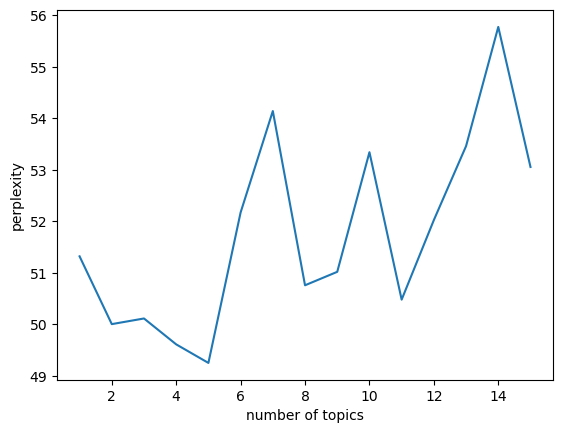

In [74]:
n_t=15#区间最右侧的值。注意：不能大于n_max_topics
x=list(range(1,n_t+1))
plt.plot(x,plexs[0:n_t])
plt.xlabel("number of topics")
plt.ylabel("perplexity")
plt.show()